문장들을 벡터의 시퀀스로 임베딩하고 펼친 후 그 위에 Dense층 훈련  
사전 훈련된 단어 임베딩 사용  
원본 텍스트 데이터로부터 처음부터 시작

In [1]:
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

print(texts[:10])
print(labels[:10])

["Can I please say first of all, that I felt so strongly about this movie that I signed up to IMDb specifically to review it. And my review? This is easily the worst movie I have ever seen.<br /><br />The synopsis of the movie sounded interesting- Nazis, occult, time travel, etc., but the movies plot failed to properly bring all these elements together. Remember the episode of South Park that featured manatees writing Family Guy using 'idea balls'? Did these manatees also write Unholy? Its like the writer wanted to include all these different ideas, but had no idea how to link them all together, and then to make things make even less sense, included a Donnie Darko-esquire time travel theme to the ending, messing up the chronology.<br /><br />I could tell from early on that this was a bad movie. Special effects were too low budget for anything better than straight to DVD. The acting wasn't great, but in fairness I've seen worse. I will praise the Nazi paintings, they were creepy, but th

훈련 데이터를 처음 200개의 샘플로 제한

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
import numpy as np

maxlen = 100 # 100개 단어 이후는 버림
training_samples = 200 # 훈련 샘플 수
validation_samples = 10000 # 검증 샘플 수
max_words = 10000 # 가장 빈도 높은 1만 개의 단어만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print("데이터 텐서의 크기:", data.shape)
print("레이블 텐서의 크기:", labels.shape)

indices = np.arange(data.shape[0]) # 훈련 세트와 검증 세트로 랜덤하게 분할을 위함
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [3]:
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print("%s개의 단어 벡터를 찾았습니다." % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


Embedding 층에 주입할 수 있도록 임베딩 행렬 만듬  
max_words, embedding_dim  
i번째 원소는 토큰화로 만든 단어 인덱스의 i번째 단어에 상응하는 embedding_dim차원 벡터

In [4]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


2022-08-31 02:59:02.549556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-31 02:59:02.612069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-31 02:59:02.612439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-31 02:59:02.615144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Embedding 층은 하나의 가중치 행렬을 가짐  
2D 부동 소수 행렬, i번째 원소는 i번째 인덱스에 상응하는 단어 벡터

In [6]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Embedding 층 동결 (trainable False)  
사전 훈련된 부분이 업데이트 되지 않도록 하기 위해

In [7]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
3/7 [===========>..................] - ETA: 0s - loss: 2.5589 - acc: 0.4375 

2022-08-31 03:02:43.149467: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 8s 543ms/step - loss: 1.6022 - acc: 0.4750 - val_loss: 0.7313 - val_acc: 0.4980
Epoch 2/10
7/7 [==============================] - 2s 291ms/step - loss: 0.6573 - acc: 0.6000 - val_loss: 0.8966 - val_acc: 0.4928
Epoch 3/10
7/7 [==============================] - 2s 307ms/step - loss: 0.5563 - acc: 0.7200 - val_loss: 0.8648 - val_acc: 0.5093
Epoch 4/10
7/7 [==============================] - 2s 304ms/step - loss: 0.3208 - acc: 0.9450 - val_loss: 1.3365 - val_acc: 0.4925
Epoch 5/10
7/7 [==============================] - 2s 274ms/step - loss: 0.3596 - acc: 0.8050 - val_loss: 0.7255 - val_acc: 0.5409
Epoch 6/10
7/7 [==============================] - 2s 281ms/step - loss: 0.3742 - acc: 0.7950 - val_loss: 1.9244 - val_acc: 0.5084
Epoch 7/10
7/7 [==============================] - 2s 281ms/step - loss: 0.2229 - acc: 0.8750 - val_loss: 0.7604 - val_acc: 0.5404
Epoch 8/10
7/7 [==============================] - 2s 259ms/step - loss: 0.0580 - acc: 1.0000 - val_lo

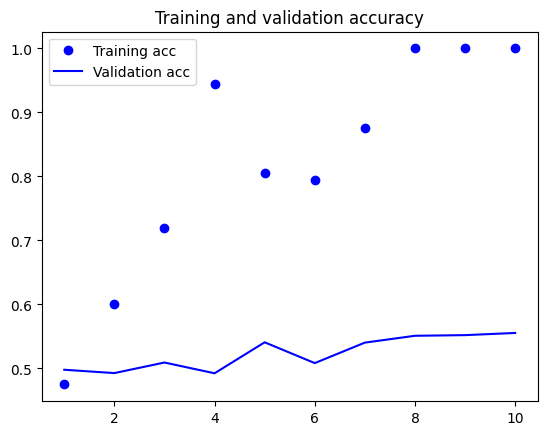

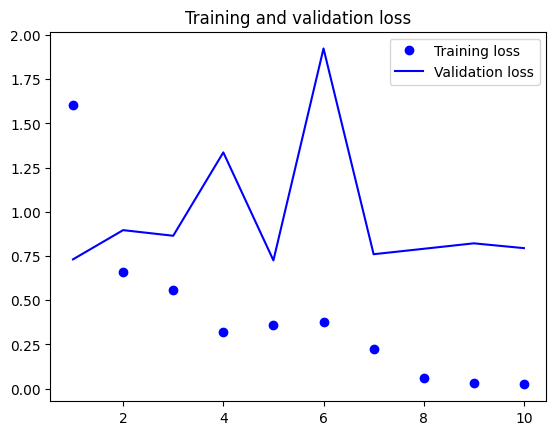

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

과대적합이 빠르게 시작되어 검증 정확도와 훈련 정확도 사이 차이가 큼  
훈련 샘플 수가 적음  
어떤 샘플 200개를 선택했는지에 따라 성능이 크게 좌우됨  
사전 훈련 단어 임베딩을 사용하지 않거나 임베딩 층을 동결하지 않고 훈련 가능  
해당 작업에 특화된 입력 토큰의 임베딩을 학습할 것  
데이터가 풍부하다면 일반적으로 사전 훈련된 단어 임베딩보다 성능이 높음

In [10]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                320032    
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 237ms/step - loss: 0.6985 - acc: 0.4600 - val_loss: 0.6926 - val_acc: 0.5166
Epoch 2/10
7/7 [==============================

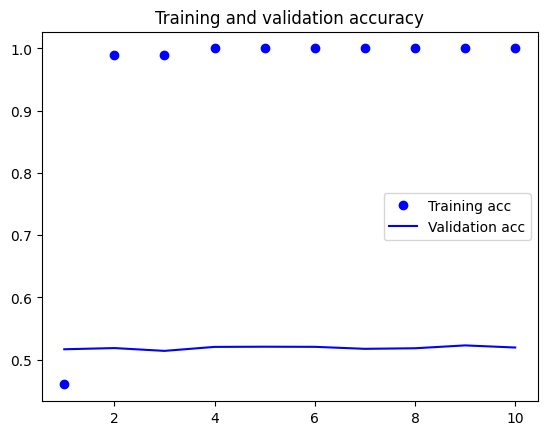

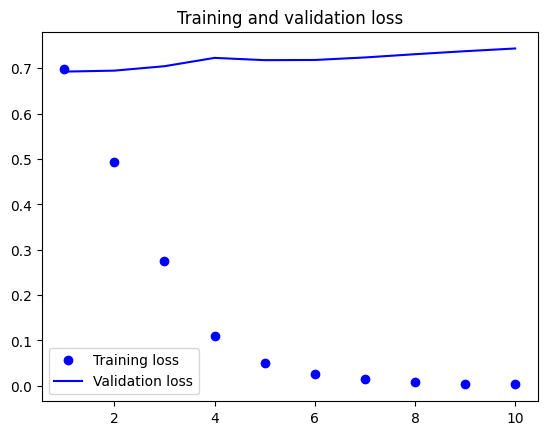

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

test data에서 모델 평가

In [12]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [13]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.7961 - acc: 0.5577


[0.7960807681083679, 0.5576800107955933]